<a href="https://colab.research.google.com/github/JoysGitHubPortfolio/RecommendationEngine/blob/main/Joy_Cowper_Muzz_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Dependencies

In [35]:
!pip install implicit
!pip install pyngrok

In [36]:
# Data processing and visuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model Serving
from flask import Flask, request, jsonify
from pyngrok import ngrok
import threading

# Environment Handling
from google.colab import userdata
import warnings
warnings.filterwarnings('ignore')

# Ingestion

In [37]:
!ls drive/MyDrive/Muzz/

swipes.zip


In [38]:
!unzip drive/MyDrive/Muzz/swipes.zip -d swipes_data

Archive:  drive/MyDrive/Muzz/swipes.zip
replace swipes_data/swipes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [39]:
df = pd.read_csv("swipes_data/swipes.csv")
df.head()

,decidermemberid,othermemberid,timestamp,like,decidergender,othergender,deciderdobyear,otherdobyear,decidersignuptimestamp,othersignuptimestamp
0,3847776,3227524,2021-01-01 00:00:06,1,M,F,2002,1999,2020-12-28 11:19:02,2020-08-17 12:46:39
1,608590,519321,2021-01-01 00:00:06,0,F,M,1996,1992,2018-08-10 22:55:32,2018-06-17 15:34:37
2,397116,453914,2021-01-01 00:00:06,0,F,M,1991,1991,2018-03-04 22:14:06,2018-04-25 21:22:26
3,3847776,1269455,2021-01-01 00:00:06,1,M,F,2002,2000,2020-12-28 11:19:02,2019-04-22 20:02:54
4,1630969,347909,2021-01-01 00:00:23,0,F,M,1980,1983,2019-08-29 00:07:22,2018-01-17 12:14:03


In [40]:
len(df)

9859578

# EDA

## Schema Statistics

In [41]:
df["like"].mean()

np.float64(0.3461672497545027)

In [42]:
unique_users = df[["decidermemberid", "decidergender"]].drop_duplicates().groupby("decidergender").size()
unique_users

,0
decidergender,
F,15196
M,36895


## Data Cleansing

In [43]:
# Observe how many same-gender interactions occur (not valid by front-end constraints)
ff_rows = len(df.loc[(df['decidergender'] == 'F') & (df['othergender'] == 'F')])
mm_rows = len(df.loc[(df['decidergender'] == 'M') & (df['othergender'] == 'M')])
print(ff_rows, mm_rows)

12556 19134


In [44]:
mask_valid = (
    (df["decidergender"] == "M") & (df["othergender"] == "F")
) | (
    (df["decidergender"] == "F") & (df["othergender"] == "M")
)

df = df[mask_valid].copy(deep=True)

In [45]:
like_rates = df.groupby(['decidergender', 'decidermemberid']).agg(num_swipes = ('like', 'size'),
                                                                  num_likes = ('like', 'sum'),
                                                                  like_rate = ('like', 'mean')).reset_index()

like_rates = like_rates[like_rates['like_rate'] > 0].copy(deep=True) # effectively filter out inactive users
like_rates = like_rates[like_rates['like_rate'] < 1].copy(deep=True) # effectively filter out spamming users

print('Number of Valid Users:', len(like_rates), '\n')
like_rates[0:5]

Number of Valid Users: 39556 



,decidergender,decidermemberid,num_swipes,num_likes,like_rate
2,F,1498,450,10,0.022222
3,F,1524,319,84,0.263323
4,F,1593,476,10,0.021008
5,F,1668,37,1,0.027027
6,F,1679,3,2,0.666667


## Visualisation

In [46]:
def plot_my_member_dists(member_counts: pd.DataFrame = like_rates,
                         variable: str = 'num_swipes',
                         log: bool = False
                         ):

  fig, axes = plt.subplots(1, 2, figsize=(6, 2.5),
                           sharey=True,
                           constrained_layout=True)
  for ax, gender in zip(axes, ['M', 'F']):
      x = member_counts.loc[member_counts['decidergender'] == gender, variable]

      if log:
        x = np.log1p(x) # use log scale and 1+probability to normalise range of values
        log_title = 'log scale'
      else:
        log_title = ''

      if variable == 'num_swipes':
        ax.set_xlim(0,1000)
        bins=500
      if variable == 'num_likes':
        ax.set_xlim(0,250)
        bins=250
      if variable == 'like_rate':
        ax.set_xlim(0,1)
        bins=250

      ax.hist(x, bins=bins, density=True)
      x.plot(kind='kde',
            ax=ax,
            bw_method=0.25)

      ax.set_title(f'{gender} - Distribution:\n{log_title}')
      ax.set_xlabel(f'{variable}')
      ax.set_ylabel('Probability Density')

  plt.show()

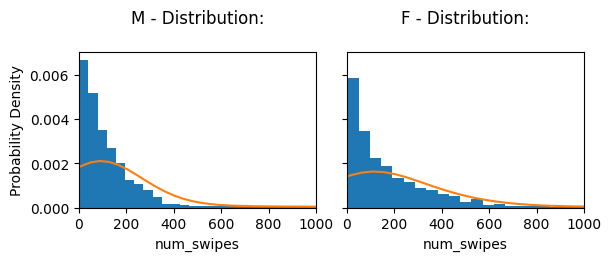

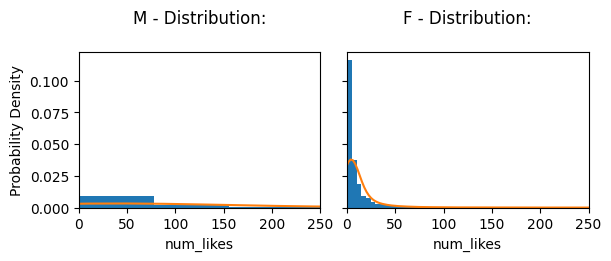

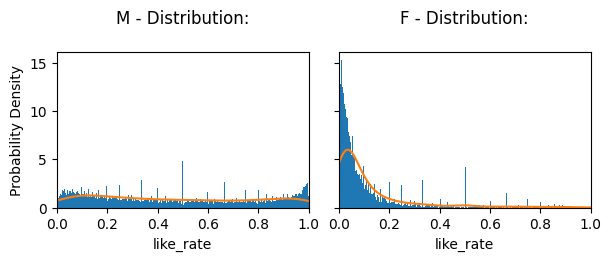

In [47]:
plot_my_member_dists(variable='num_swipes')
plot_my_member_dists(variable='num_likes')
plot_my_member_dists(variable='like_rate')

# Feature Engineering

In [48]:
# keep  deciders whose (gender, id) with non-0, non-spam likes
valid_deciders = like_rates[['decidergender', 'decidermemberid']]

df_filtered = df.merge(
    valid_deciders,
    on=['decidergender', 'decidermemberid'],
    how='inner'
).copy(deep=True)

df_filtered.shape

(9228495, 10)

In [49]:
# check filtered interactions df has only users that had valid like_rate
len(df_filtered['decidermemberid'].unique())

39556

In [50]:
# check retained users have like_rate between (0, 1)
check = (
    df_filtered
    .groupby(['decidergender', 'decidermemberid'])['like']
    .mean()
)

check.min(), check.max()

(0.00026232948583420777, 0.9998963945296312)

In [51]:
df_filtered[0:5]

,decidermemberid,othermemberid,timestamp,like,decidergender,othergender,deciderdobyear,otherdobyear,decidersignuptimestamp,othersignuptimestamp
0,3847776,3227524,2021-01-01 00:00:06,1,M,F,2002,1999,2020-12-28 11:19:02,2020-08-17 12:46:39
1,608590,519321,2021-01-01 00:00:06,0,F,M,1996,1992,2018-08-10 22:55:32,2018-06-17 15:34:37
2,397116,453914,2021-01-01 00:00:06,0,F,M,1991,1991,2018-03-04 22:14:06,2018-04-25 21:22:26
3,3847776,1269455,2021-01-01 00:00:06,1,M,F,2002,2000,2020-12-28 11:19:02,2019-04-22 20:02:54
4,1630969,347909,2021-01-01 00:00:23,0,F,M,1980,1983,2019-08-29 00:07:22,2018-01-17 12:14:03


In [52]:
# This means what's the like rate when users saw each other in their queues compared to when they didn't.
# We take all pairs of user IDs and see if they map in reverse.
# This result shows that users are more prone to like each other if they saw each other.

pairs = set(zip(df_filtered.decidermemberid, df_filtered.othermemberid))
df_filtered["reciprocal_possible"] = [
    (o, d) in pairs for d, o in zip(df_filtered.decidermemberid, df_filtered.othermemberid)
]

df_filtered.groupby("reciprocal_possible")["like"].mean()

,like
reciprocal_possible,
False,0.331027
True,0.476074


In [53]:
len(pairs)

8682963

# Model Build

In [54]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9228495 entries, 0 to 9228494
Data columns (total 11 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   decidermemberid         int64 
 1   othermemberid           int64 
 2   timestamp               object
 3   like                    int64 
 4   decidergender           object
 5   othergender             object
 6   deciderdobyear          int64 
 7   otherdobyear            int64 
 8   decidersignuptimestamp  object
 9   othersignuptimestamp    object
 10  reciprocal_possible     bool  
dtypes: bool(1), int64(5), object(5)
memory usage: 712.9+ MB


## Data Preparation

In [55]:
# Filter for likes only (like=1 means positive interaction)
interactions = df_filtered[df_filtered['like'] == 1].copy(deep=True)

# Count interactions per user-item pair (confidence measure)
interaction_counts = interactions.groupby(['decidermemberid', 'othermemberid']).size().reset_index(name='interaction_count')

# Create user and item mappings
unique_users = interaction_counts['decidermemberid'].unique()
unique_items = interaction_counts['othermemberid'].unique()

user_mapping = {user: idx for idx, user in enumerate(unique_users)}
item_mapping = {item: idx for idx, item in enumerate(unique_items)}
reverse_user_mapping = {idx: user for user, idx in user_mapping.items()}
reverse_item_mapping = {idx: item for item, idx in item_mapping.items()}

# Map to matrix indices
interaction_counts['user_idx'] = interaction_counts['decidermemberid'].map(user_mapping)
interaction_counts['item_idx'] = interaction_counts['othermemberid'].map(item_mapping)

print(f"Users: {len(unique_users)}, Items: {len(unique_items)}")
print(f"Total interactions: {len(interaction_counts)}")

Users: 39556, Items: 77148
Total interactions: 2980643


## Train-Test Split & Evaluate

In [56]:
# Hyperparameters (somewhat arbitrary/relative) - could use grid-search in future to optimise.
FACTORS = 64
REGULARIZATION = 0.01
ITERATIONS = 20
ALPHA = 40
TEST_SIZE = 0.2

# Split data into train and test
print(f"\nSplitting data: {int((1-TEST_SIZE)*100)}% train, {int(TEST_SIZE*100)}% test")
train_data, test_data = train_test_split(
    interaction_counts,
    test_size=TEST_SIZE,
    random_state=42
)

# Create train matrix with confidence weighting
train_confidence = 1 + ALPHA * train_data['interaction_count']
train_matrix = csr_matrix(
    (train_confidence,
     (train_data['user_idx'], train_data['item_idx'])),
    shape=(len(user_mapping), len(item_mapping))
)

# Create test matrix
test_confidence = 1 + ALPHA * test_data['interaction_count']
test_matrix = csr_matrix(
    (test_confidence,
     (test_data['user_idx'], test_data['item_idx'])),
    shape=(len(user_mapping), len(item_mapping))
)

# Train the ALS model
print(f"\nTraining ALS model...")
print(f"Parameters: factors={FACTORS}, regularization={REGULARIZATION}, "
      f"iterations={ITERATIONS}, alpha={ALPHA}")

model = AlternatingLeastSquares(
    factors=FACTORS,
    regularization=REGULARIZATION,
    iterations=ITERATIONS,
    random_state=42
)

model.fit(train_matrix)
print("Training complete!")

# Evaluate model performance
print(f"\nEvaluating model (Top-10 recommendations)...")

K = 10
precisions = []
recalls = []

# Group test data by user
test_grouped = test_data.groupby('user_idx')['item_idx'].apply(list).to_dict()

for user_idx, actual_items in test_grouped.items():
    if user_idx >= train_matrix.shape[0]:
        continue

    # Get recommendations
    user_items = train_matrix[user_idx]
    ids, scores = model.recommend(
        user_idx,
        user_items,
        N=K,
        filter_already_liked_items=True
    )

    recommended_items = ids.tolist()

    # Calculate metrics
    hits = len(set(recommended_items) & set(actual_items))
    precision = hits / K if K > 0 else 0
    recall = hits / len(actual_items) if len(actual_items) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

print(f"Precision@{K}: {avg_precision:.4f}")
print(f"Recall@{K}: {avg_recall:.4f}")


Splitting data: 80% train, 20% test

Training ALS model...
Parameters: factors=64, regularization=0.01, iterations=20, alpha=40


  0%|          | 0/20 [00:00<?, ?it/s]

Training complete!

Evaluating model (Top-10 recommendations)...
Precision@10: 0.1014
Recall@10: 0.1086


## Visualisation


Visualization saved as 'recommendation_results.png'


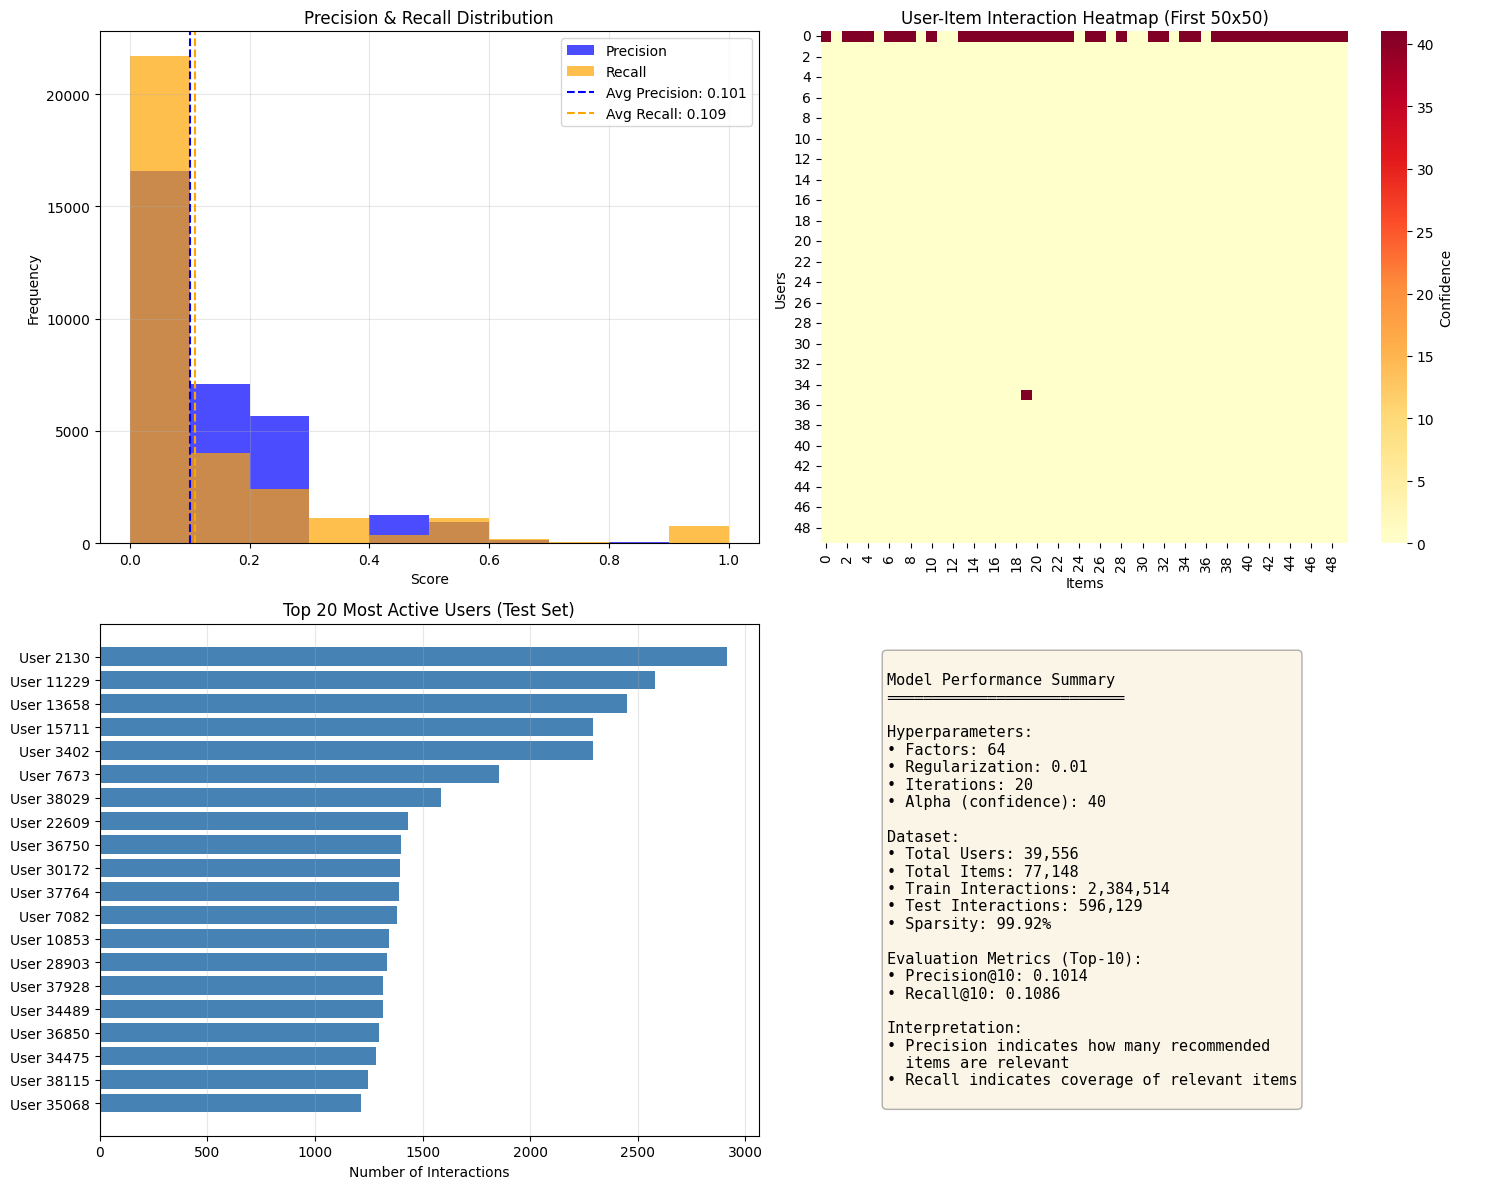

In [57]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Precision and Recall Distribution
ax1 = axes[0, 0]
ax1.hist(precisions, bins=10, alpha=0.7, label='Precision', color='blue')
ax1.hist(recalls, bins=10, alpha=0.7, label='Recall', color='orange')
ax1.axvline(avg_precision, color='blue', linestyle='--',
            label=f"Avg Precision: {avg_precision:.3f}")
ax1.axvline(avg_recall, color='orange', linestyle='--',
            label=f"Avg Recall: {avg_recall:.3f}")
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Precision & Recall Distribution')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Interaction density heatmap (sample)
ax2 = axes[0, 1]
sample_size = min(50, train_matrix.shape[0])
sample_matrix = train_matrix[:sample_size, :sample_size].toarray()
sns.heatmap(sample_matrix, cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Confidence'})
ax2.set_title(f'User-Item Interaction Heatmap (First {sample_size}x{sample_size})')
ax2.set_xlabel('Items')
ax2.set_ylabel('Users')

# 3. Top users by interaction count
ax3 = axes[1, 0]
user_interactions = test_data.groupby('user_idx').size().sort_values(ascending=False).head(20)
ax3.barh(range(len(user_interactions)), user_interactions.values, color='steelblue')
ax3.set_yticks(range(len(user_interactions)))
ax3.set_yticklabels([f"User {idx}" for idx in user_interactions.index])
ax3.set_xlabel('Number of Interactions')
ax3.set_title('Top 20 Most Active Users (Test Set)')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Model performance summary
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
Model Performance Summary
══════════════════════════

Hyperparameters:
• Factors: {FACTORS}
• Regularization: {REGULARIZATION}
• Iterations: {ITERATIONS}
• Alpha (confidence): {ALPHA}

Dataset:
• Total Users: {len(user_mapping):,}
• Total Items: {len(item_mapping):,}
• Train Interactions: {train_matrix.nnz:,}
• Test Interactions: {len(test_data):,}
• Sparsity: {(1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100:.2f}%

Evaluation Metrics (Top-10):
• Precision@10: {avg_precision:.4f}
• Recall@10: {avg_recall:.4f}

Interpretation:
• Precision indicates how many recommended
  items are relevant
• Recall indicates coverage of relevant items
"""

ax4.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('recommendation_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'recommendation_results.png'")
plt.show()

# Explainability

Embedding dimensions: (39556, 64)
Number of users: 39556
Embedding size (latent factors): 64
Sampling 5000 users from 39556 for visualization speed...
Creating visualizations...


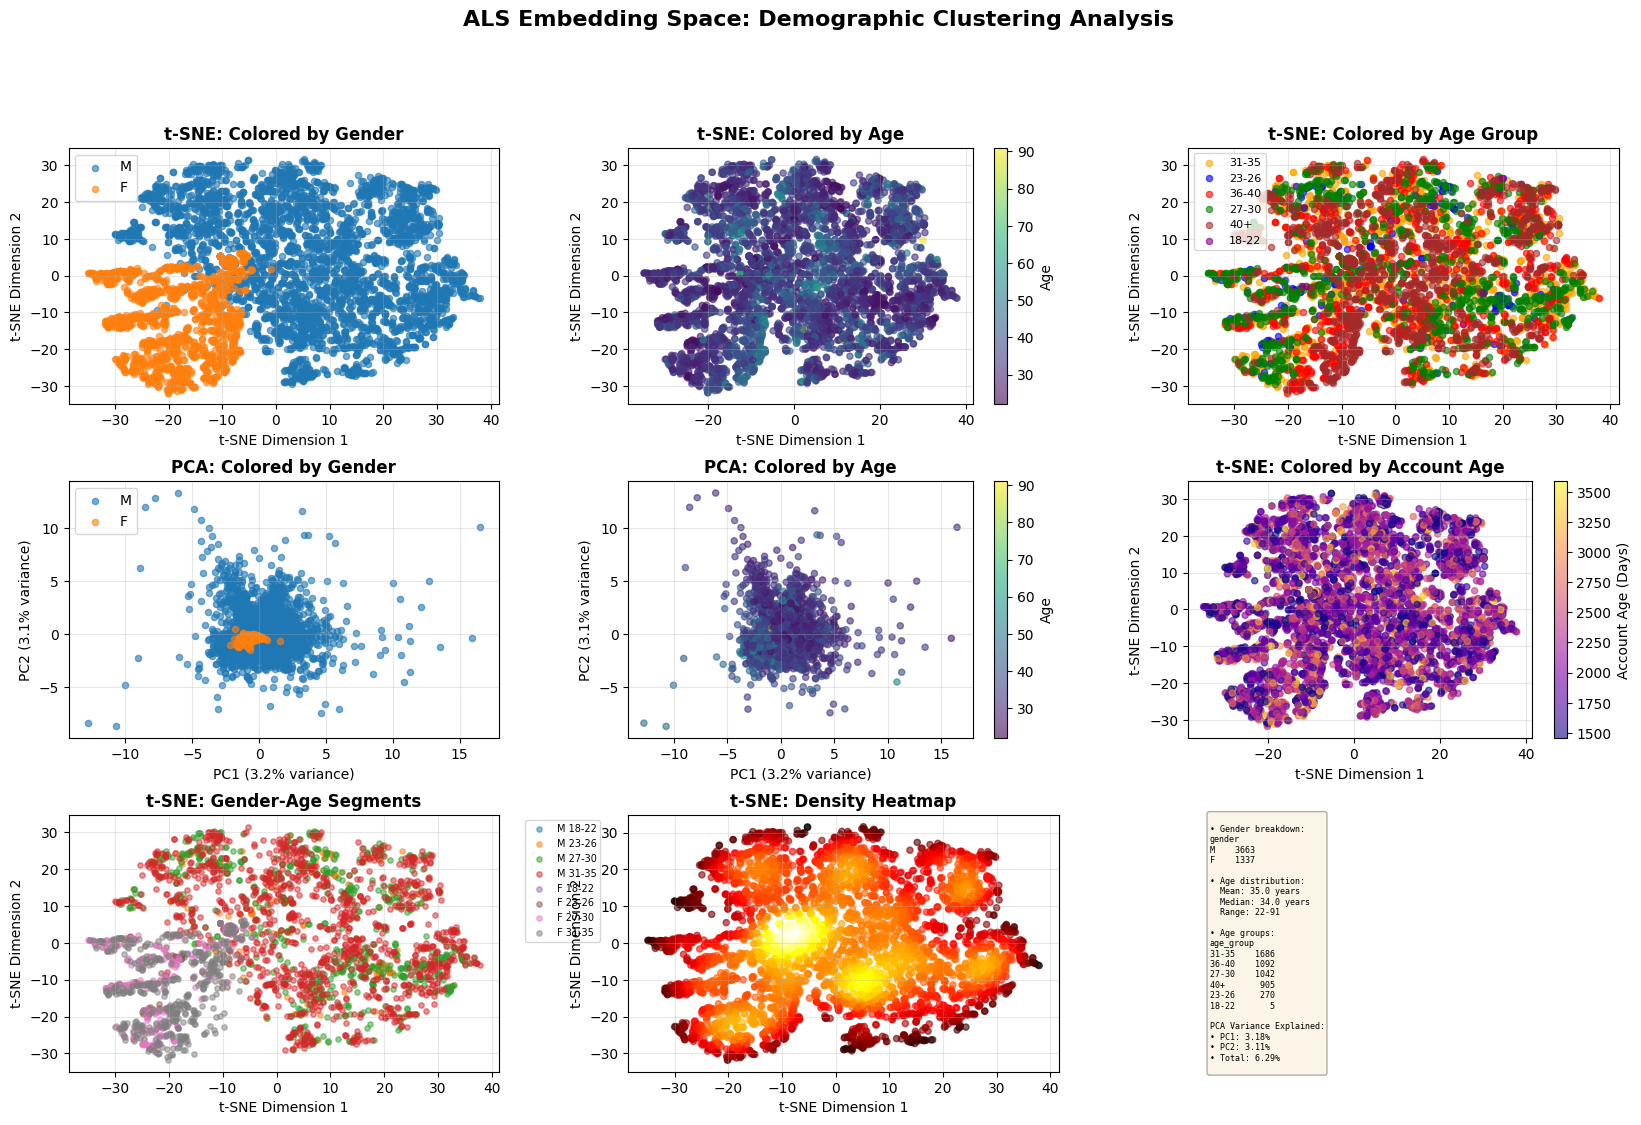


CLUSTERING ANALYSIS

Avg distance between F and M: 9.460

AGE GROUP SEPARATION
Avg distance between 31-35 and 23-26: 9.390
Avg distance between 31-35 and 36-40: 11.385
Avg distance between 31-35 and 27-30: 10.594
Avg distance between 31-35 and 40+: 10.872
Avg distance between 31-35 and 18-22: 8.259
Avg distance between 23-26 and 36-40: 9.881
Avg distance between 23-26 and 27-30: 9.085
Avg distance between 23-26 and 40+: 9.892
Avg distance between 23-26 and 18-22: 6.652
Avg distance between 36-40 and 27-30: 10.647
Avg distance between 36-40 and 40+: 11.469
Avg distance between 36-40 and 18-22: 8.886
Avg distance between 27-30 and 40+: 10.504
Avg distance between 27-30 and 18-22: 7.942
Avg distance between 40+ and 18-22: 8.767


In [58]:
# Get the learned user factor matrix (embeddings): model.user_factors shape: (n_users, n_factors)
user_embeddings = model.user_factors
print(f"Embedding dimensions: {user_embeddings.shape}")
print(f"Number of users: {len(user_mapping)}")
print(f"Embedding size (latent factors): {user_embeddings.shape[1]}")

# Create a dataframe with user IDs and their embeddings
embedding_df = pd.DataFrame(user_embeddings)
embedding_df['user_idx'] = range(len(user_embeddings))
embedding_df['user_id'] = embedding_df['user_idx'].map(reverse_user_mapping)

# Merge with demographic information
user_demographics = df_filtered[['decidermemberid', 'decidergender', 'deciderdobyear', 'decidersignuptimestamp']].copy()
user_demographics = user_demographics.drop_duplicates('decidermemberid')
user_demographics.columns = ['user_id', 'gender', 'dob_year', 'signup_timestamp']

embedding_df = embedding_df.merge(user_demographics, on='user_id', how='left')

# Calculate age and account age
current_year = 2025
embedding_df['age'] = current_year - embedding_df['dob_year']
embedding_df['signup_timestamp'] = pd.to_datetime(embedding_df['signup_timestamp'])
embedding_df['account_age_days'] = (pd.Timestamp('2025-01-01') - embedding_df['signup_timestamp']).dt.days

# Create age groups
embedding_df['age_group'] = pd.cut(embedding_df['age'],
                                    bins=[0, 22, 26, 30, 35, 40, 100],
                                    labels=['18-22', '23-26', '27-30', '31-35', '36-40', '40+'])

# Sample users if dataset is large (for speed)
max_users_to_plot = 5000
if len(user_embeddings) > max_users_to_plot:
    print(f"Sampling {max_users_to_plot} users from {len(user_embeddings)} for visualization speed...")
    sample_idx = np.random.choice(len(user_embeddings), max_users_to_plot, replace=False)
    user_embeddings_sample = user_embeddings[sample_idx]
    embedding_df = embedding_df.iloc[sample_idx].reset_index(drop=True)
else:
    user_embeddings_sample = user_embeddings

# Use t-SNE to reduce to 2D (captures non-linear relationships: Using faster parameters: lower perplexity and iterations
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(user_embeddings_sample)//4),
            n_iter=500, n_jobs=-1, verbose=0)
embeddings_2d_tsne = tsne.fit_transform(user_embeddings_sample)

# Use PCA to reduce to 2D (captures linear relationships)
pca = PCA(n_components=2, random_state=42)
embeddings_2d_pca = pca.fit_transform(user_embeddings_sample)

# Add to dataframe
embedding_df['tsne_x'] = embeddings_2d_tsne[:, 0]
embedding_df['tsne_y'] = embeddings_2d_tsne[:, 1]
embedding_df['pca_x'] = embeddings_2d_pca[:, 0]
embedding_df['pca_y'] = embeddings_2d_pca[:, 1]

print("Creating visualizations...")
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. t-SNE colored by gender
ax1 = fig.add_subplot(gs[0, 0])
for gender in embedding_df['gender'].dropna().unique():
    mask = embedding_df['gender'] == gender
    ax1.scatter(embedding_df[mask]['tsne_x'],
               embedding_df[mask]['tsne_y'],
               alpha=0.6, s=20, label=gender)
ax1.set_title('t-SNE: Colored by Gender', fontsize=12, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1')
ax1.set_ylabel('t-SNE Dimension 2')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. t-SNE colored by age
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(embedding_df['tsne_x'],
                      embedding_df['tsne_y'],
                      c=embedding_df['age'],
                      cmap='viridis',
                      alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax2, label='Age')
ax2.set_title('t-SNE: Colored by Age', fontsize=12, fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')
ax2.grid(alpha=0.3)

# 3. t-SNE colored by age group
ax3 = fig.add_subplot(gs[0, 2])
age_colors = {'18-22': 'purple', '23-26': 'blue', '27-30': 'green',
              '31-35': 'orange', '36-40': 'red', '40+': 'brown'}
for age_group in embedding_df['age_group'].dropna().unique():
    mask = embedding_df['age_group'] == age_group
    ax3.scatter(embedding_df[mask]['tsne_x'],
               embedding_df[mask]['tsne_y'],
               alpha=0.6, s=20, label=age_group,
               color=age_colors.get(age_group, 'gray'))
ax3.set_title('t-SNE: Colored by Age Group', fontsize=12, fontweight='bold')
ax3.set_xlabel('t-SNE Dimension 1')
ax3.set_ylabel('t-SNE Dimension 2')
ax3.legend(loc='best', fontsize=8)
ax3.grid(alpha=0.3)

# 4. PCA colored by gender
ax4 = fig.add_subplot(gs[1, 0])
for gender in embedding_df['gender'].dropna().unique():
    mask = embedding_df['gender'] == gender
    ax4.scatter(embedding_df[mask]['pca_x'],
               embedding_df[mask]['pca_y'],
               alpha=0.6, s=20, label=gender)
ax4.set_title('PCA: Colored by Gender', fontsize=12, fontweight='bold')
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. PCA colored by age
ax5 = fig.add_subplot(gs[1, 1])
scatter = ax5.scatter(embedding_df['pca_x'],
                      embedding_df['pca_y'],
                      c=embedding_df['age'],
                      cmap='viridis',
                      alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax5, label='Age')
ax5.set_title('PCA: Colored by Age', fontsize=12, fontweight='bold')
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax5.grid(alpha=0.3)

# 6. t-SNE colored by account age
ax6 = fig.add_subplot(gs[1, 2])
scatter = ax6.scatter(embedding_df['tsne_x'],
                      embedding_df['tsne_y'],
                      c=embedding_df['account_age_days'],
                      cmap='plasma',
                      alpha=0.6, s=20)
plt.colorbar(scatter, ax=ax6, label='Account Age (Days)')
ax6.set_title('t-SNE: Colored by Account Age', fontsize=12, fontweight='bold')
ax6.set_xlabel('t-SNE Dimension 1')
ax6.set_ylabel('t-SNE Dimension 2')
ax6.grid(alpha=0.3)

# 7. Gender-Age interaction (t-SNE)
ax7 = fig.add_subplot(gs[2, 0])
for gender in embedding_df['gender'].dropna().unique():
    for age_group in ['18-22', '23-26', '27-30', '31-35']:
        mask = (embedding_df['gender'] == gender) & (embedding_df['age_group'] == age_group)
        if mask.sum() > 0:
            ax7.scatter(embedding_df[mask]['tsne_x'],
                       embedding_df[mask]['tsne_y'],
                       alpha=0.5, s=15, label=f'{gender} {age_group}')
ax7.set_title('t-SNE: Gender-Age Segments', fontsize=12, fontweight='bold')
ax7.set_xlabel('t-SNE Dimension 1')
ax7.set_ylabel('t-SNE Dimension 2')
ax7.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
ax7.grid(alpha=0.3)

# 8. Density plot
ax8 = fig.add_subplot(gs[2, 1])
from scipy.stats import gaussian_kde
xy = np.vstack([embedding_df['tsne_x'].dropna(), embedding_df['tsne_y'].dropna()])
z = gaussian_kde(xy)(xy)
ax8.scatter(embedding_df['tsne_x'], embedding_df['tsne_y'],
           c=z, s=20, cmap='hot', alpha=0.6)
ax8.set_title('t-SNE: Density Heatmap', fontsize=12, fontweight='bold')
ax8.set_xlabel('t-SNE Dimension 1')
ax8.set_ylabel('t-SNE Dimension 2')
ax8.grid(alpha=0.3)

# 9. Summary statistics
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

summary_text = f"""
• Gender breakdown:
{embedding_df['gender'].value_counts().to_string()}

• Age distribution:
  Mean: {embedding_df['age'].mean():.1f} years
  Median: {embedding_df['age'].median():.1f} years
  Range: {embedding_df['age'].min():.0f}-{embedding_df['age'].max():.0f}

• Age groups:
{embedding_df['age_group'].value_counts().to_string()}

PCA Variance Explained:
• PC1: {pca.explained_variance_ratio_[0]:.2%}
• PC2: {pca.explained_variance_ratio_[1]:.2%}
• Total: {pca.explained_variance_ratio_[:2].sum():.2%}
"""

ax9.text(0.05, 0.5, summary_text, fontsize=6, verticalalignment='center',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('ALS Embedding Space: Demographic Clustering Analysis',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('embedding_space_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical analysis of clustering
print("\n" + "="*60)
print("CLUSTERING ANALYSIS")
print("="*60)

# Analyze separation between genders in embedding space
from scipy.spatial.distance import cdist

for gender1 in embedding_df['gender'].dropna().unique():
    for gender2 in embedding_df['gender'].dropna().unique():
        if gender1 < gender2:  # Avoid duplicates
            emb1 = user_embeddings_sample[embedding_df['gender'] == gender1]
            emb2 = user_embeddings_sample[embedding_df['gender'] == gender2]

            # Sample for efficiency
            if len(emb1) > 1000:
                emb1 = emb1[np.random.choice(len(emb1), 1000, replace=False)]
            if len(emb2) > 1000:
                emb2 = emb2[np.random.choice(len(emb2), 1000, replace=False)]

            # Calculate average distance
            if len(emb1) > 0 and len(emb2) > 0:
                distances = cdist(emb1, emb2, metric='euclidean')
                avg_distance = np.mean(distances)
                print(f"\nAvg distance between {gender1} and {gender2}: {avg_distance:.3f}")

# Analyze age clustering
print("\n" + "="*60)
print("AGE GROUP SEPARATION")
print("="*60)

age_groups = embedding_df['age_group'].dropna().unique()
for i, ag1 in enumerate(age_groups):
    for ag2 in age_groups[i+1:]:
        emb1 = user_embeddings_sample[embedding_df['age_group'] == ag1]
        emb2 = user_embeddings_sample[embedding_df['age_group'] == ag2]

        if len(emb1) > 500:
            emb1 = emb1[np.random.choice(len(emb1), 500, replace=False)]
        if len(emb2) > 500:
            emb2 = emb2[np.random.choice(len(emb2), 500, replace=False)]

        if len(emb1) > 0 and len(emb2) > 0:
            distances = cdist(emb1, emb2, metric='euclidean')
            avg_distance = np.mean(distances)
            print(f"Avg distance between {ag1} and {ag2}: {avg_distance:.3f}")

# Deployment

## Local Inference

In [59]:
def generate_match_queue(user_id, queue_length=20):
    # Check if user exists in training data
    if user_id not in user_mapping:
        print(f"New user {user_id} - using popularity-based recommendations")
        # For cold start users, return most popular items
        item_popularity = np.array(train_matrix.sum(axis=0)).flatten()
        top_items_idx = np.argsort(item_popularity)[::-1][:queue_length]

        results = []
        for item_idx in top_items_idx:
            if item_idx in reverse_item_mapping:
                original_id = reverse_item_mapping[item_idx]
                score = float(item_popularity[item_idx])
                results.append((original_id, score))
        return results

    # Get user index
    user_idx = user_mapping[user_id]
    user_items = train_matrix[user_idx]

    # Get recommendations from model
    ids, scores = model.recommend(
        user_idx,
        user_items,
        N=queue_length,
        filter_already_liked_items=True
    )

    # Convert back to original IDs
    results = []
    for item_idx, score in zip(ids, scores):
        original_id = reverse_item_mapping[item_idx]
        results.append((original_id, float(score)))
    return results


# Example usage: Generate a match queue
user_to_serve = df_filtered['decidermemberid'].iloc[0]
desired_queue_length = 20

match_queue = generate_match_queue(user_to_serve, queue_length=desired_queue_length)
for rank, (other_user_id, score) in enumerate(match_queue[:desired_queue_length], 1):
    user_data = df_filtered[df_filtered['decidermemberid'] == other_user_id].iloc[0] if len(df_filtered[df_filtered['decidermemberid'] == other_user_id]) > 0 else None

    if user_data is not None:
        gender = user_data.get('decidergender', 'Unknown')
        age = 2025 - user_data.get('deciderdobyear', 2000)
        print(f"{rank:2d}. User {other_user_id} | Score: {score:.4f} | {gender}, Age {age}")
    else:
        print(f"{rank:2d}. User {other_user_id} | Score: {score:.4f}")

# Test with different queue lengths
print(f"\n{'='*60}")
print("Queue Length Comparison:")
print(f"{'='*60}\n")

for length in [5, 10, 20, 50]:
    queue = generate_match_queue(user_to_serve, queue_length=length)
    avg_score = np.mean([score for _, score in queue])
    print(f"Queue length {length:2d}: {len(queue)} matches | Avg score: {avg_score:.4f}")

 1. User 3469135 | Score: 1.3586 | F, Age 23
 2. User 2973580 | Score: 1.2822 | F, Age 23
 3. User 2388271 | Score: 1.2550 | F, Age 26
 4. User 3864277 | Score: 1.2290 | F, Age 23
 5. User 2184748 | Score: 1.2062 | F, Age 24
 6. User 2726767 | Score: 1.1890
 7. User 2828482 | Score: 1.1870 | F, Age 26
 8. User 3786299 | Score: 1.1836 | F, Age 26
 9. User 3879991 | Score: 1.1815 | F, Age 23
10. User 3833777 | Score: 1.1810 | F, Age 23
11. User 3700309 | Score: 1.1696 | F, Age 23
12. User 3805767 | Score: 1.1623 | F, Age 25
13. User 3867283 | Score: 1.1419 | F, Age 25
14. User 3860422 | Score: 1.1407
15. User 2105883 | Score: 1.1378 | F, Age 25
16. User 3664524 | Score: 1.1297 | F, Age 24
17. User 3727392 | Score: 1.1260 | F, Age 26
18. User 2550833 | Score: 1.1197 | F, Age 25
19. User 3719268 | Score: 1.1197 | F, Age 26
20. User 3731564 | Score: 1.1173 | F, Age 23

Queue Length Comparison:

Queue length  5: 5 matches | Avg score: 1.2662
Queue length 10: 10 matches | Avg score: 1.2253
Qu

## Serving via API

In [60]:
try:
  if type(userdata.get('NGROK')) == str:
    print('Found secret')
except:
  print('Check environment for secrets')

Found secret


In [61]:
# (get free token from https://dashboard.ngrok.com/get-started/your-authtoken)
ngrok.set_auth_token(userdata.get('NGROK'))

# Create Flask app
app = Flask(__name__)

@app.route('/recommend', methods=['GET'])
def recommend():
    """
    Get recommendations via GET request
    Usage: curl "http://your-url.ngrok-free.app/recommend?user_id=12345&queue_length=10"
    """
    try:
        user_id = int(request.args.get('user_id'))
        queue_length = int(request.args.get('queue_length', 20))

        # Generate recommendations
        match_queue = generate_match_queue(user_id, queue_length=queue_length)

        # Format response
        recommendations = []
        for rank, (other_user_id, score) in enumerate(match_queue, 1):
            user_data = df_filtered[df_filtered['decidermemberid'] == other_user_id]

            if len(user_data) > 0:
                user_data = user_data.iloc[0]
                recommendations.append({
                    'rank': rank,
                    'user_id': int(other_user_id),
                    'score': round(float(score), 4),
                    'gender': user_data.get('decidergender', 'Unknown'),
                    'age': int(2025 - user_data.get('deciderdobyear', 2000))
                })
            else:
                recommendations.append({
                    'rank': rank,
                    'user_id': int(other_user_id),
                    'score': round(float(score), 4)
                })

        return jsonify({
            'user_id': user_id,
            'queue_length': queue_length,
            'recommendations': recommendations
        })

    except Exception as e:
        return jsonify({'error': str(e)}), 400

# Start Flask in background thread
def run_flask():
    app.run(port=5000, use_reloader=False)

threading.Thread(target=run_flask, daemon=True).start()

# Create ngrok tunnel
public_url = ngrok.connect(5000)
print(f"\n{'='*70}")
print(f"API IS LIVE!")
print(f"{'='*70}")
print(f"Public URL: {public_url}")
print(f"\Test from CMD:")
print(f'curl "{public_url}/recommend?user_id={user_to_serve}&queue_length=10"')
print(f"\n{'='*70}\n")

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.



API IS LIVE!
Public URL: NgrokTunnel: "https://vegetative-lulu-urogenital.ngrok-free.dev" -> "http://localhost:5000"
\Test from CMD:
curl "NgrokTunnel: "https://vegetative-lulu-urogenital.ngrok-free.dev" -> "http://localhost:5000"/recommend?user_id=3847776&queue_length=10"




## CURL

In [62]:
!curl "https://vegetative-lulu-urogenital.ngrok-free.dev/recommend?user_id=3847776&queue_length=10"

INFO:werkzeug:127.0.0.1 - - [26/Dec/2025 21:27:43] "GET /recommend?user_id=3847776&queue_length=10 HTTP/1.1" 200 -


{"queue_length":10,"recommendations":[{"age":23,"gender":"F","rank":1,"score":1.3586,"user_id":3469135},{"age":23,"gender":"F","rank":2,"score":1.2822,"user_id":2973580},{"age":26,"gender":"F","rank":3,"score":1.255,"user_id":2388271},{"age":23,"gender":"F","rank":4,"score":1.229,"user_id":3864277},{"age":24,"gender":"F","rank":5,"score":1.2062,"user_id":2184748},{"rank":6,"score":1.189,"user_id":2726767},{"age":26,"gender":"F","rank":7,"score":1.187,"user_id":2828482},{"age":26,"gender":"F","rank":8,"score":1.1836,"user_id":3786299},{"age":23,"gender":"F","rank":9,"score":1.1815,"user_id":3879991},{"age":23,"gender":"F","rank":10,"score":1.181,"user_id":3833777}],"user_id":3847776}


# Export to GitHub

In [63]:
!ls -lh '/content/drive/MyDrive/Colab Notebooks/Joy Cowper Muzz Pipeline.ipynb'

-rw------- 1 root root 397K Dec 26 21:27 '/content/drive/MyDrive/Colab Notebooks/Joy Cowper Muzz Pipeline.ipynb'
